In [653]:
# Author: Rahul Nandakumar (E-ID: rn9355)
# Question 6 - All parts
# Making the necessary imports

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy
from random import sample
import math
from scipy.special import gamma

In [654]:
# Defining our Normal(0,1) distribution to sample values from. 

x = np.linspace(-1, 1, 10000)
y = norm.pdf(x)

In [655]:
# Defining our support sigma^2 from 0.1 to 1

sigma2 = np.linspace(0.1, 1, 10000)

In [656]:
# Calculation of the prior distribution in accordance with the Jeffrey's prior

priors = 1/sigma2

Text(0, 0.5, 'Prior')

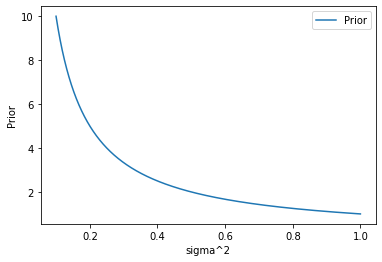

In [671]:
# Visualizing the prior distribution

plt.plot(sigma2, priors, label = "Prior")
plt.legend(loc = "upper right")
plt.xlabel('sigma^2')
plt.ylabel('Prior')

In [658]:
# Calculating the parameters of the Inverse Gamma Distribution

alpha = 10
sum = 0
samples = sample(y.tolist(), 20)
ys = [(y**2)for y in samples]
beta = np.sum(np.asarray(ys))/2 

In [660]:
# Function definition for the pdf of a Inverse Gamma Distribution

def calculate_inverse_gamma(sigma):
    return scipy.stats.invgamma.pdf(sigma, a = alpha, scale = beta)

In [661]:
# We calculat the posterior values, as the inverse gamma distribution over the support with parameters alpha and beta as calculate above

posteriors = calculate_inverse_gamma(sigma2)

Text(0, 0.5, 'Prior/Posterior')

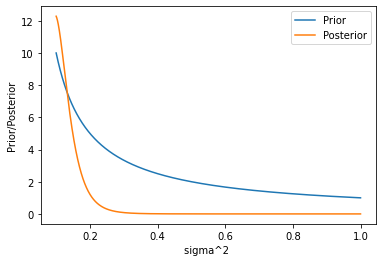

In [662]:
# Visualizing the posterior superimposed over the prior

plt.plot(sigma2, priors, label = "Prior")
plt.plot(sigma2, posteriors, label = "Posterior")
plt.legend(loc = "upper right")
plt.xlabel('sigma^2 ')
plt.ylabel('Prior/Posterior')

Text(0, 0.5, 'Posterior')

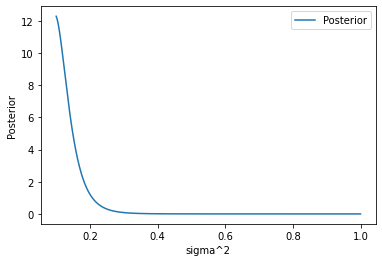

In [663]:
# Visualizing the posterior distribution only. 

plt.plot(sigma2, posteriors, label = "Posterior")
plt.legend(loc = "upper right")
plt.xlabel('sigma^2')
plt.ylabel('Posterior')

In [664]:
# Function definition to calculate the HPD intervals

from __future__ import division
import numpy as np
import scipy.stats.kde as kde

def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
         x_hpd = x[(x > value[0]) & (x < value[1])]
         y_hpd = y[(x > value[0]) & (x < value[1])]
         modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [665]:
# Function definition to calculate the random variates used to calculate the inverse cdf and then find the quantiles

def rvs(x, pdf, nvals):
    cumulative = np.cumsum(pdf(x))
    cumulative *= 1/cumulative[-1]

    randomvals = np.random.uniform(size = nvals)
    idx1 = np.searchsorted(cumulative, randomvals)
    idx0 = np.where(idx1 == 0, 0, idx1 - 1)
    idx1[idx0 == 0] = 1

    frac1 = (randomvals - cumulative[idx0])/ (cumulative[idx1] - cumulative[idx0])

    return x[idx0]*(1-frac1) + x[idx1]*frac1

In [666]:
# We find the random variates by calling the rvs function

random_variates = rvs(sigma2, calculate_inverse_gamma, 100000)

In [667]:
# Making use of the quantile function in the numpy package, we calculate the 0.05 and 0.95 quantiles. 

quantile1 = np.quantile(random_variates, 0.05)
quantile2 = np.quantile(random_variates, 0.95)
quantile1, quantile2

(0.10242307810098894, 0.21316013463489708)

Text(0, 0.5, 'Posterior')

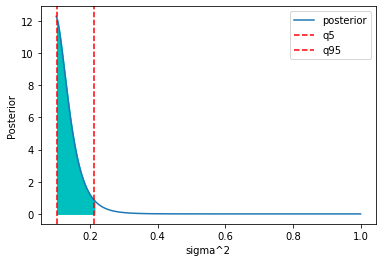

In [677]:
# Visualizing the quantile based credible region for the posterior

plt.plot(sigma2, posteriors, label = 'posterior')
plt.axvline(x = quantile1, color = 'r',  ls = '--', label = 'q5')
plt.axvline(x = quantile2, color = 'r',  ls = '--', label = 'q95') 
condition1 = (sigma2 >=quantile1)
condition2 = (sigma2 <= quantile2)
plt.fill_between(sigma2, posteriors, where = (condition1) & (condition2), color='c')
plt.legend(loc="upper right")
plt.xlabel('sigma^2')
plt.ylabel('Posterior')

In [669]:
# We find the hpd intrevals by calling the hpd grid function. 

hpd = hpd_grid(random_variates, alpha = 0.1)[0][0]

In [672]:
hpd

(0.1, 0.19)

Text(0, 0.5, 'Posterior')

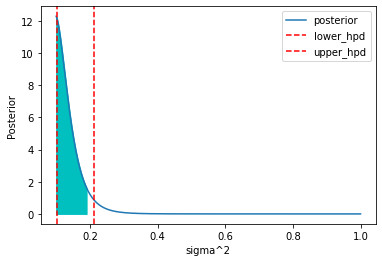

In [678]:
# Visualizing the HPD based credible region for the posterior

plt.plot(sigma2, posteriors, label = 'posterior')
plt.axvline(x = quantile1, color = 'r',  ls = '--', label = 'lower_hpd')
plt.axvline(x = quantile2, color = 'r',  ls = '--', label = 'upper_hpd') 
condition1 = (sigma2 >= hpd[0])
condition2 = (sigma2 <= hpd[1])
plt.fill_between(sigma2, posteriors, where = (condition1) & (condition2), color='c')
plt.legend(loc="upper right")
plt.xlabel('sigma^2')
plt.ylabel('Posterior')